<a href="https://colab.research.google.com/github/componavt/LLLE-R1900s/blob/main/src/visualization/credit_trends_by_settlement_and_type.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 📈 Rural Credit Trends in Early 20th Century Russia

This notebook visualizes loan amount trends over time, broken down by:
- **Settlements** (villages, volosts, etc.)
- **Credit types** (e.g., FarmBuildings, Livestock, Housing)

Data source: cleaned CSV from `csv_out/`, specified in `config.env`.

Built for Google Colab. Just click "Run All" to generate plots.

In [1]:
# Install required packages (if not already installed)
!pip install -q python-dotenv pandas matplotlib

In [2]:
# Clone the repo if running in Colab (optional — if data not uploaded manually)
import os

if not os.path.exists('LLLE-R1900s'):
    !git clone https://github.com/componavt/LLLE-R1900s.git
    %cd LLLE-R1900s
else:
    %cd LLLE-R1900s

Cloning into 'LLLE-R1900s'...
remote: Enumerating objects: 119, done.
remote: Counting objects: 100% (119/119), done.
remote: Compressing objects: 100% (73/73), done.
remote: Total 119 (delta 63), reused 85 (delta 40), pack-reused 0 (from 0)
Receiving objects: 100% (119/119), 259.49 KiB | 1.42 MiB/s, done.
Resolving deltas: 100% (63/63), done.
/content/LLLE-R1900s


In [3]:
import os
import pandas as pd
from dotenv import load_dotenv
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from datetime import datetime

# Load configuration
load_dotenv('config.env')

# Get output directory and target file
csv_out_dir = os.getenv('CSV_OUT_DIR', 'data/csv_out')
output_file_name = os.getenv('OUTPUT_CSV_FILE')

# If not specified, use the first CSV in the directory
if not output_file_name:
    csv_files = [f for f in os.listdir(csv_out_dir) if f.endswith('.csv')]
    if not csv_files:
        raise FileNotFoundError("No CSV files found in the output directory.")
    output_file_name = csv_files[0]

csv_path = os.path.join(csv_out_dir, output_file_name)
print(f"Loading data from: {csv_path}")

# Load data
df = pd.read_csv(csv_path)
print(f"Loaded {len(df)} loan records.")
df.head()

Loading data from: data/csv_out/loans_s4_i16.csv
Loaded 148 loan records.


,year,settlement,month_start,month_end,credit_item,loan_count,amount_rubles,loan_details
0,1916,Ivinskoye,4,6,FarmBuildings,1,25,NaN
1,1916,Ivinskoye,4,6,LandImprovement,2,400,NaN
2,1916,Ivinskoye,4,6,Livestock,3,250,NaN
3,1916,Ivinskoye,4,6,Rent,1,50,NaN
4,1916,Ivinskoye,4,6,Migration,1,35,NaN


In [4]:
# Calculate midpoint month for each loan period
df['mid_month'] = ((df['month_start'] + df['month_end']) // 2).astype(int)

# Create a proper datetime column (first day of the midpoint month)
df['date'] = pd.to_datetime(df['year'].astype(str) + '-' + df['mid_month'].astype(str) + '-01')

# Ensure output directory exists for saving plots
os.makedirs('outputs', exist_ok=True)

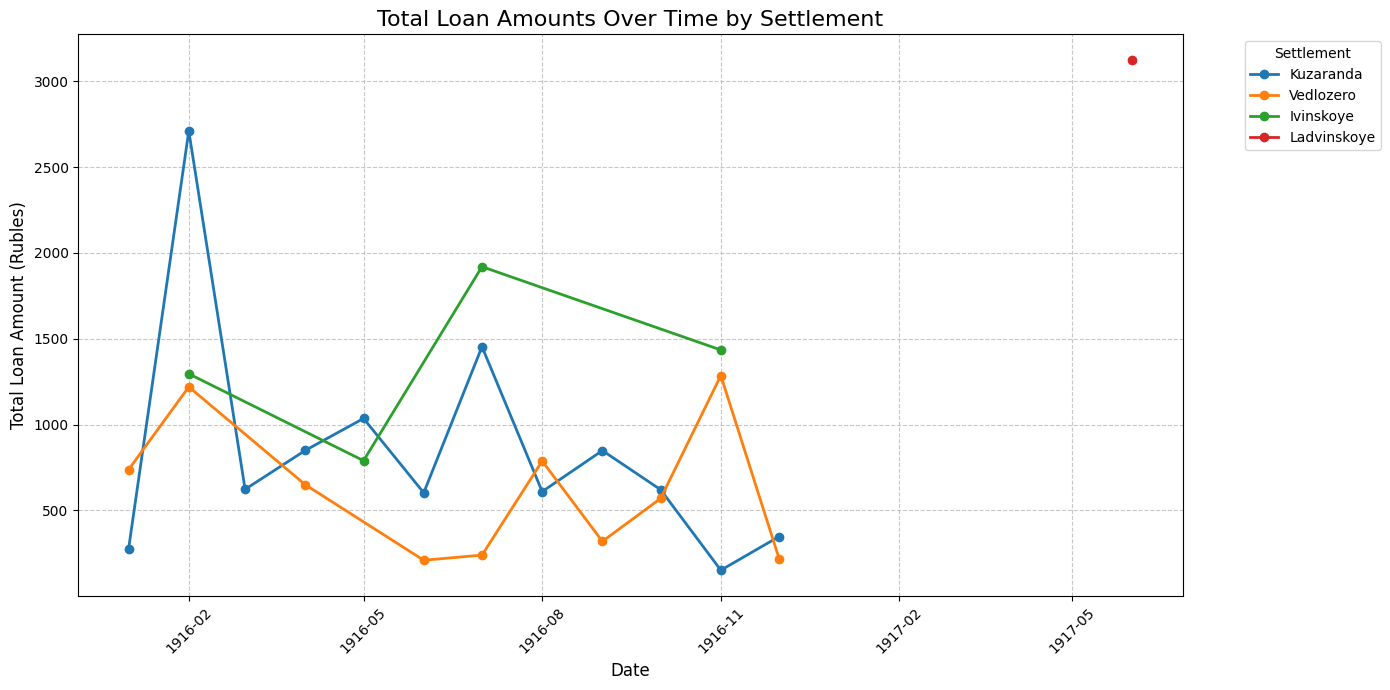

In [5]:
# Aggregate by date and settlement
grouped_by_settlement = df.groupby(['date', 'settlement'])['amount_rubles'].sum().reset_index()

# Plot
plt.figure(figsize=(14, 7))
for settlement in grouped_by_settlement['settlement'].unique():
    subset = grouped_by_settlement[grouped_by_settlement['settlement'] == settlement]
    plt.plot(subset['date'], subset['amount_rubles'], label=settlement, marker='o', linestyle='-', linewidth=2)

plt.title('Total Loan Amounts Over Time by Settlement', fontsize=16)
plt.xlabel('Date', fontsize=12)
plt.ylabel('Total Loan Amount (Rubles)', fontsize=12)
plt.legend(title='Settlement', bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=10)
plt.grid(True, linestyle='--', alpha=0.7)
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
plt.gca().xaxis.set_major_locator(mdates.MonthLocator(interval=3))
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig('outputs/loans_by_settlement.png', dpi=150)
plt.show()

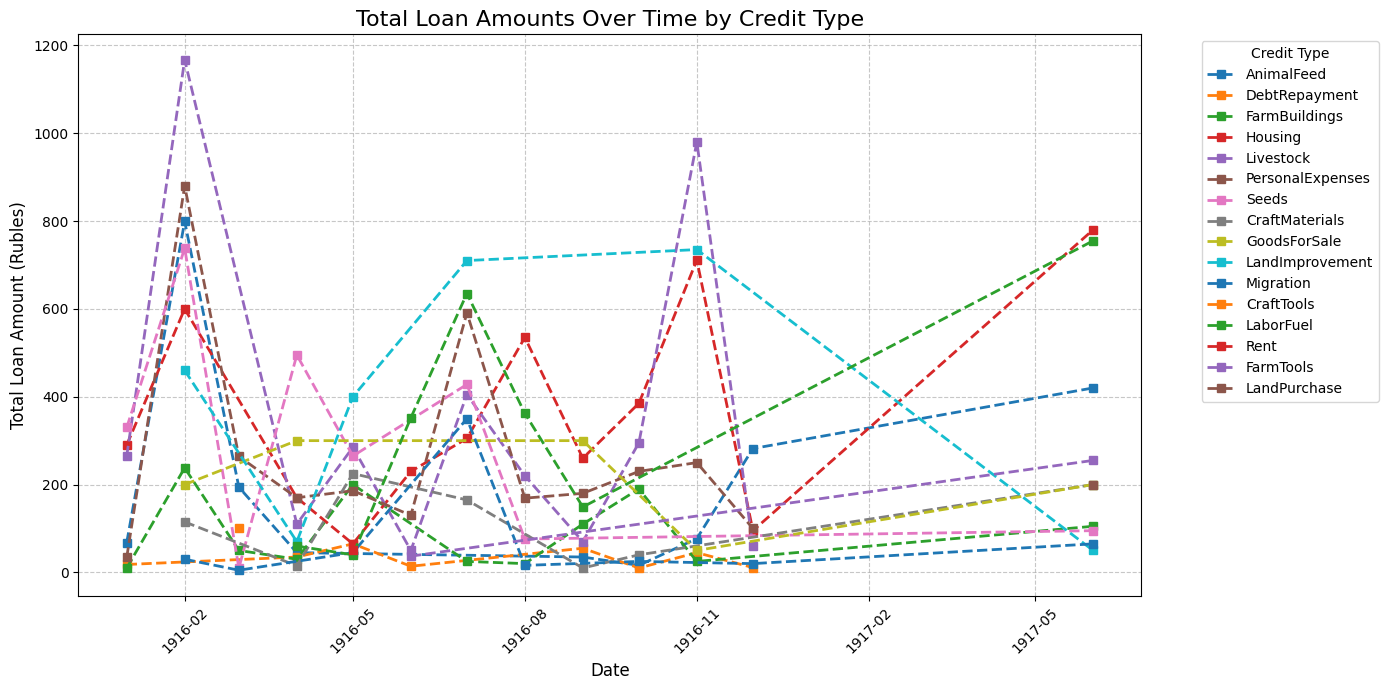

In [6]:
# Aggregate by date and credit item
grouped_by_credit = df.groupby(['date', 'credit_item'])['amount_rubles'].sum().reset_index()

# Plot
plt.figure(figsize=(14, 7))
for credit_item in grouped_by_credit['credit_item'].unique():
    subset = grouped_by_credit[grouped_by_credit['credit_item'] == credit_item]
    plt.plot(subset['date'], subset['amount_rubles'], label=credit_item, marker='s', linestyle='--', linewidth=2)

plt.title('Total Loan Amounts Over Time by Credit Type', fontsize=16)
plt.xlabel('Date', fontsize=12)
plt.ylabel('Total Loan Amount (Rubles)', fontsize=12)
plt.legend(title='Credit Type', bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=10)
plt.grid(True, linestyle='--', alpha=0.7)
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
plt.gca().xaxis.set_major_locator(mdates.MonthLocator(interval=3))
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig('outputs/loans_by_credit_item.png', dpi=150)
plt.show()